2023-08-30 18:30:01.643 python[30589:24348123] +[CATransaction synchronize] called within transaction
2023-08-30 18:30:01.685 python[30589:24348123] +[CATransaction synchronize] called within transaction
2023-08-30 18:30:01.931 python[30589:24348123] +[CATransaction synchronize] called within transaction
2023-08-30 18:30:03.010 python[30589:24348123] +[CATransaction synchronize] called within transaction


File: GRB007_20230830_164407_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------


/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_30589/606368354.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((4, 5), (0, 0), colspan=1)
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_30589/606368354.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((4, 5), (0, 1), colspan=1)
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_30589/606368354.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((4, 5), (0, 2), colspan=1)
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_30589/606368354.py:43: 

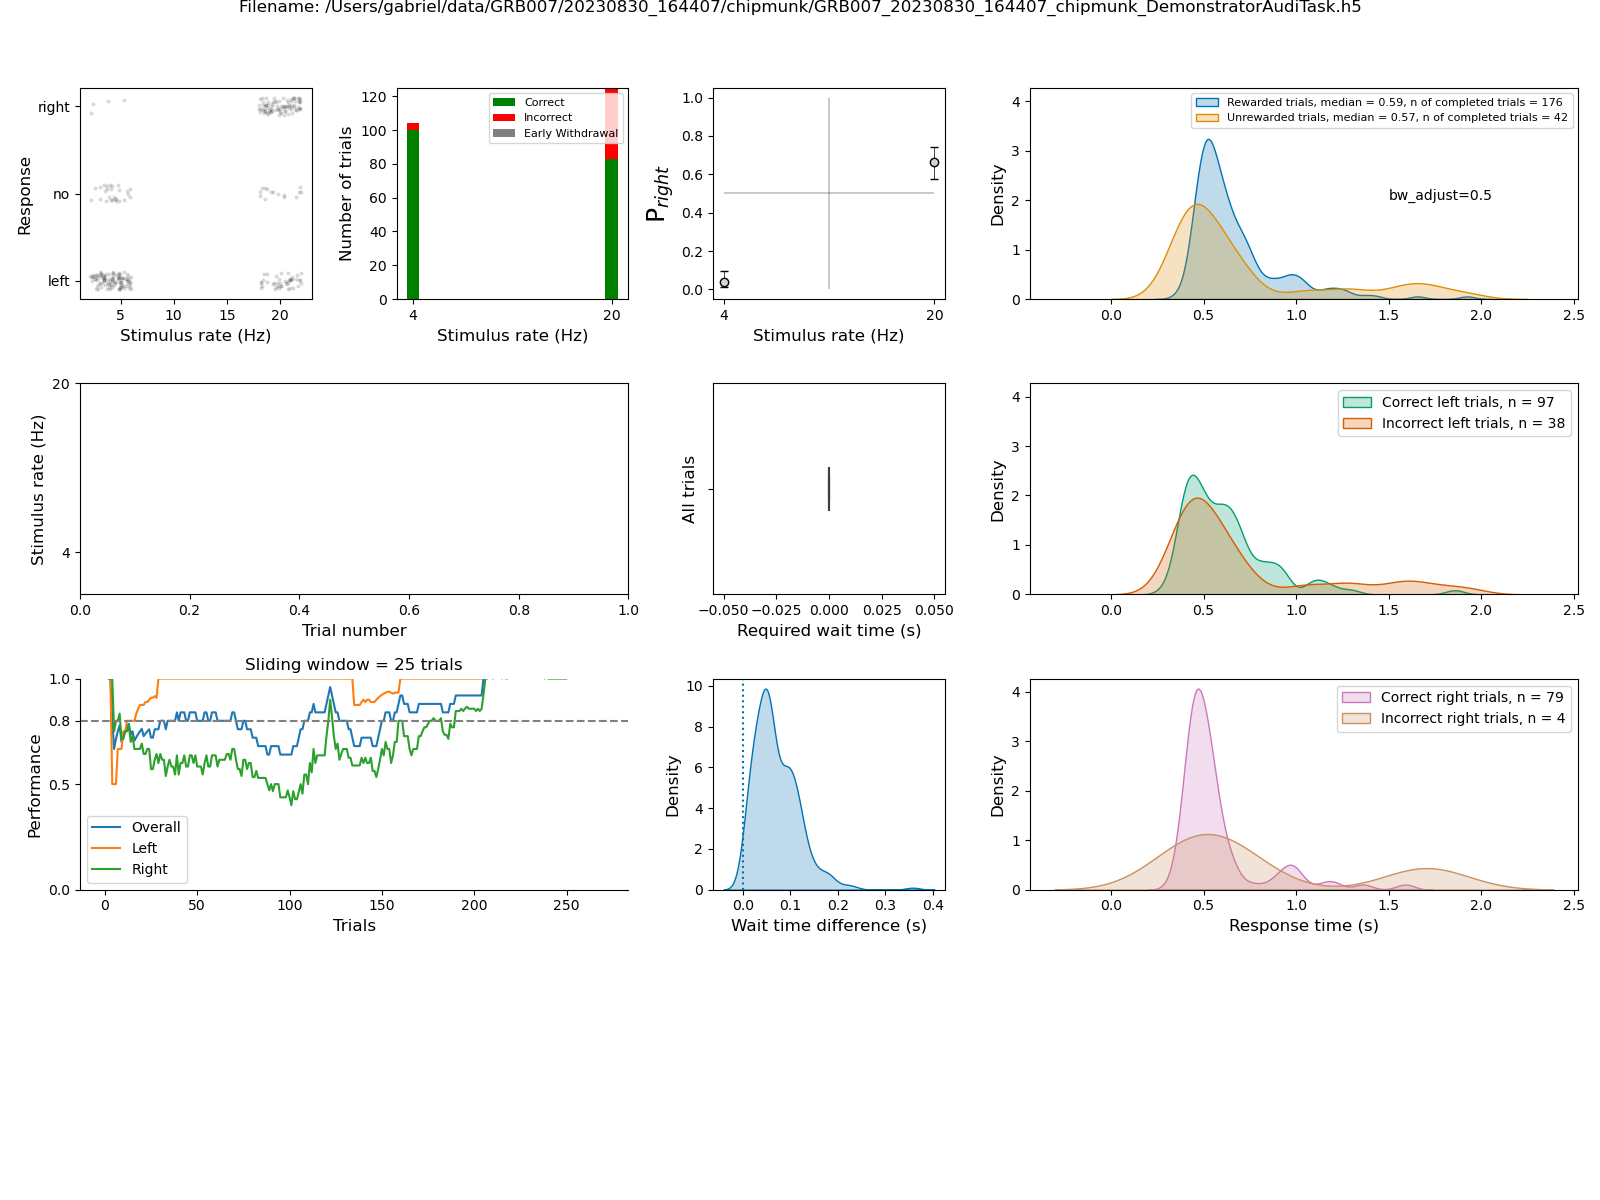

In [14]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
from glob import glob # to search files 
import seaborn as sns
# import sys; sys.path.append('..') # this is not needed if you install the module
from chipmunk_performance_plots import *
%matplotlib widget

def performance_summary(filename=None, cutoff=2, window=50):
    """
    Plots several behavioral measurements from a chipmunk session in a single figure. 

    Gabriel Rojas Bowe, Aug 2023.

    Adapted from code supplied by Joao Couto and Lukas Oesch.
    """
    fn = pick_files("*.mat")
    h5file = convert_specified_behavior_sessions(fn)
    session_data = pd.read_hdf(h5file[0])

    # session_data = pd.read_hdf(filename)

    ntrials = len(session_data)
    ntrials_with_choice = len(session_data[session_data['outcome_record'].isin([0, 1])])
    stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
    unique_stim_rates = np.unique(stim_rates)

    response = []
    for r in session_data.response_side:
        if r == 0: #left choice
            response.append(-1)
        elif r == 1: #right choice
            response.append(r)
        else: #no choice/early withdrawal
            response.append(0)

    fig = plt.figure(1,figsize=([16, 12]))

    ax1 = plt.subplot2grid((4, 5), (0, 0), colspan=1) 
    ax2 = plt.subplot2grid((4, 5), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((4, 5), (0, 2), colspan=1)
    ax4 = plt.subplot2grid((4, 5), (1, 0), colspan=2)
    ax5 = plt.subplot2grid((4, 5), (1, 2), colspan=1)
    ax6 = plt.subplot2grid((4, 5), (2, 2), colspan=1)
    ax7 = plt.subplot2grid((4, 5), (0, 3), colspan=2)
    ax8 = plt.subplot2grid((4, 5), (1, 3), colspan=2, sharex=ax7, sharey=ax7)
    ax9 = plt.subplot2grid((4, 5), (2, 3), colspan=2, sharex=ax7, sharey=ax7)
    ax10 = plt.subplot2grid((4, 5), (2, 0), colspan=2)

    colors = sns.color_palette('colorblind') #for consistency

    # First plot - response+noise per stimulus rate
    ax1.plot(stim_rates + np.random.uniform(-2, 2, len(session_data)),
             response + np.random.uniform(-0.1, 0.1, len(session_data)),
             'ko', alpha=0.1, markersize=2)
    
    ax1.set_ylabel('Response', fontsize = 12)
    ax1.set_xlabel('Stimulus rate (Hz)', fontsize = 12)
    ax1.set_yticks([-1, 0, 1], ['left', 'no', 'right'])
    ax1.set_title("\n")

    # Second plot - response color-coded by outcome throughout the session
    c = []
    for i, (s, r) in enumerate(zip(np.array(stim_rates), np.array(response))):
        if ((s > 12) & (r > 0)) | ((s < 12) & (r < 0)):
            c.append('green')
        elif ((s == 12) & (session_data.outcome_record[i] == 1)):
            c.append('green')
        elif ((s == 12) & (session_data.outcome_record[i] == 0)):
            c.append('red')
        elif r == 0:
            c.append('grey')
        else:
            c.append('red')

    ax4.scatter(np.arange(len(stim_rates)), stim_rates, 5, c=c, alpha=0.5)
    ax4.set_ylabel('Stimulus rate (Hz)', fontsize = 12)
    ax4.set_yticks([*unique_stim_rates])
    ax4.set_xlabel('Trial number', fontsize = 12)

    # ax2.scatter([], [], 5, c='green', label='Correct', alpha=0.5)
    # ax2.scatter([], [], 5, c='red', label='Wrong', alpha=0.5)
    # ax2.scatter([], [], 5, c='grey', label='No response', alpha=0.5)
    # ax2.legend(loc='upper right', fontsize=8)


    # Third plot - histogram showing outcome record by trial type
    correct_responses = (session_data.outcome_record == 1)
    incorrect_responses = (session_data.outcome_record == 0)
    no_choice_responses = (session_data.outcome_record == -1)

    # Unique stim intensities
    correct = np.zeros_like(unique_stim_rates)
    incorrect = np.zeros_like(unique_stim_rates)
    no_choice = np.zeros_like(unique_stim_rates)
    # count the trials
    for i,rate in enumerate(unique_stim_rates):
        # print(i,rate)
        correct[i] = np.sum(correct_responses[np.array(stim_rates) == rate])
        incorrect[i] = np.sum(incorrect_responses[np.array(stim_rates) == rate])
        no_choice[i] = np.sum(no_choice_responses[np.array(stim_rates) == rate])

    # make a figure
    ax2.bar(unique_stim_rates,correct,width = 1,color = 'green', label='Correct')                # correct choices in BLACK
    ax2.bar(unique_stim_rates,incorrect,bottom = correct,width = 1,color='red', label='Incorrect') # incorrect choices in RED
    ax2.bar(unique_stim_rates,no_choice,bottom = correct+incorrect,width = 1,color='gray', label='Early Withdrawal') # no choice in GRAY
    ax2.set_xlabel('Stimulus rate (Hz)', fontsize = 12) # set the x-axis label
    ax2.set_ylabel('Number of trials', fontsize = 12) # set the y-axis label
    ax2.set_xticks([*unique_stim_rates])
    ax2.legend(loc='upper right', fontsize = 8)

    # Fourth plot - psychometric points + 95% CI
    sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
    responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
    sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])

    # This is the function that does the actual computing, the rest is trial selection and plotting
    stims, p_side, ci_side, n_obs, n_side = compute_proportions(stim_values=sel_stim_rates, response_values=responded_right)

    ax3.vlines(12,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
    ax3.hlines(0.5,np.min(stims),np.max(stims),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance

    # plot the observed data and confidence intervals
    for i,e in zip(stims,ci_side):  # plot the confidence intervals
        ax3.plot(i*np.array([1,1]),e,'_-',lw=0.5,color = 'black')
    ax3.plot(stims,p_side,'ko',markerfacecolor = 'lightgray',markersize = 6)

    ax3.set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
    ax3.set_xlabel('Stimulus rate (Hz)', fontsize = 12); # set the x-axis label
    ax3.set_xticks([*unique_stim_rates])

    # Fifth plot - visualize required wait times
    wait_times = session_data.waitTime
    actual_wait_times = session_data.actual_wait_time

    wait_time_diff = []
    for array1, array2 in zip(wait_times, actual_wait_times):
        wait_time_diff.append(array2-array1)


    sns.boxplot(x=wait_times, width=0.2, ax=ax5, boxprops={"facecolor": (.4, .6, .8, .5)})

    ax5.set_xlabel('Required wait time (s)', fontsize = 12)
    ax5.set_ylabel('All trials', fontsize = 12)
    
    # Sixth plot - kde of wait time differences
    sns.kdeplot(x=wait_time_diff, fill=True, color=colors[0], ax=ax6)
    ax6.set_xlabel('Wait time difference (s)', fontsize = 12)
    ax6.set_ylabel('Density', fontsize = 12)
    ax6.axvline(0, c=colors[0], linestyle='dotted')


    # Seventh plot - kde of response times
    rewarded_response_period = np.zeros((len(session_data), 2))
    rewarded_response_period[:, 0] = [trial[0] for trial in session_data.DemonWaitForResponse]
    rewarded_response_period[:, 1] = [trial[1] for trial in session_data.DemonReward]

    unrewarded_response_period = np.zeros((len(session_data), 2))
    unrewarded_response_period[:, 0] = [trial[0] for trial in session_data.DemonWaitForResponse]
    unrewarded_response_period[:, 1] = [trial[1] for trial in session_data.DemonWrongChoice]

    rewarded_response_seconds = np.diff(rewarded_response_period, axis=1)[:, 0]
    unrewarded_response_seconds = np.diff(unrewarded_response_period, axis=1)[:, 0]

    rewarded_median = np.nanmedian(rewarded_response_seconds)
    unrewarded_median = np.nanmedian(unrewarded_response_seconds)

    # print(rewarded_response_seconds)
    # cutoff after 5s to remove outliers - lcv is 'last common value'
    rewarded_response_seconds_lcv = []
    lcv=cutoff
    for trial in rewarded_response_seconds:
        if trial>lcv:
            continue
        else:
            rewarded_response_seconds_lcv.append(trial)

    unrewarded_response_seconds_lcv = []
    for trial in unrewarded_response_seconds:
        if trial>lcv:
            continue
        else:
            unrewarded_response_seconds_lcv.append(trial)


    #get number of trials for each condition
    rewarded_response_seconds_non_nan_lcv = np.count_nonzero(~np.isnan(rewarded_response_seconds_lcv))
    unrewarded_response_seconds_non_nan_lcv = np.count_nonzero(~np.isnan(unrewarded_response_seconds_lcv))

    #plot rewarded and unrewarded response
    colors = sns.color_palette('colorblind') #for consistency
    sns.kdeplot(x=rewarded_response_seconds_lcv, ax=ax7, color=colors[0], fill=True,label=f'Rewarded trials, median = {rewarded_median:.2f}, n of completed trials = {rewarded_response_seconds_non_nan_lcv}',  bw_adjust = 0.5) # bw_adjust = 1,  cumulative=True, common_norm=False, common_grid=True
    sns.kdeplot(x=unrewarded_response_seconds_lcv, ax=ax7, color=colors[1], fill=True,label=f'Unrewarded trials, median = {unrewarded_median:.2f}, n of completed trials = {unrewarded_response_seconds_non_nan_lcv}', bw_adjust = 0.5)
    # plt.axvline(rewarded_median, c=colors[0], alpha=0.7, linestyle='dotted')
    # plt.axvline(unrewarded_median, c=colors[1], alpha=0.7, linestyle='dotted')
    # ax7.set_xlabel('Response time (s)', fontsize = 12)
    ax7.set_ylabel('Density', fontsize = 12)
    ax7.text(1.5,2,'bw_adjust=0.5')
    ax7.legend(fontsize=8)

    # sns.histplot(x=rewarded_response_seconds_lcv, ax=ax8, alpha=0.5, color=colors[0], fill=True,label=f'Rewarded trials, median = {rewarded_median:.2f}, n of completed trials = {rewarded_response_seconds_non_nan_lcv}', binwidth= 0.05, element='step', stat='percent') # bw_adjust = 1,  cumulative=True, common_norm=False, common_grid=True
    # sns.histplot(x=unrewarded_response_seconds_lcv, ax=ax8, alpha=0.5, color=colors[1], fill=True,label=f'Unrewarded trials, median = {unrewarded_median:.2f}, n of completed trials = {unrewarded_response_seconds_non_nan_lcv}', binwidth = 0.05, element='step', stat='percent')
    # ax8.set_xlabel('Response time (s)', fontsize = 12)
    # ax8.set_ylabel('Percent of trials', fontsize = 12)

    #######

    # # Categorize trials
    correct_left, correct_right, incorrect_left, incorrect_right, _ = categorize_trials(sessiondata = session_data)

    # # Getting response times for all trials with a response
    # response_times = pd.DataFrame([np.diff(x) for x in session_data.DemonWaitForResponse])
    # response_times = response_times.dropna()
    # response_times = response_times.reset_index(drop=True)
    # response_times = np.array(response_times)
    # response_times = response_times[response_times!=np.array(session_data.ExtraStimulusDuration).reshape(len(response_times),1)]
    # response_times = np.array(response_times).reshape(len(response_times),1)
    response_times = np.array(pd.DataFrame([np.diff(x) for i,x in enumerate(session_data.DemonWaitForResponse) if session_data.outcome_record[i] == 0 or session_data.outcome_record[i] == 1]))
    # response_times = np.array(response_times)
    
    # print(len(response_times))
    # print(len(to_reshape))
    # import sys
    # sys.exit()

    # # Allocate response times to the different categories
    correct_left_response_times, correct_right_response_times, incorrect_left_response_times, incorrect_right_response_times = allocate_response_times(response_times, correct_left, correct_right, incorrect_left, incorrect_right)

    # # Cutoff values after 2s
    cutoff_times = {'correct_left_response_times_cutoff': cutoff_response_times(response_times = correct_left_response_times, cutoff=cutoff), 
                    'correct_right_response_times_cutoff': cutoff_response_times(response_times = correct_right_response_times, cutoff=cutoff),
                    'incorrect_left_response_times_cutoff': cutoff_response_times(response_times = incorrect_left_response_times, cutoff=cutoff),
                    'incorrect_right_response_times_cutoff': cutoff_response_times(response_times = incorrect_right_response_times, cutoff=cutoff)}

    # # # Plotting
    sns.kdeplot(x=cutoff_times['correct_left_response_times_cutoff'], ax=ax8, color=colors[2], fill=True, label=f"Correct left trials, n = {len(cutoff_times['correct_left_response_times_cutoff'])}", bw_adjust = 0.5) # bw_adjust = 1,  cumulative=True, common_norm=False, common_grid=True
    sns.kdeplot(x=cutoff_times['incorrect_left_response_times_cutoff'], ax=ax8, color=colors[3], fill=True, label=f"Incorrect left trials, n = {len(cutoff_times['incorrect_left_response_times_cutoff'])}", bw_adjust = 0.5)

    sns.kdeplot(x=cutoff_times['correct_right_response_times_cutoff'], ax=ax9, color=colors[4], fill=True, label=f"Correct right trials, n = {len(cutoff_times['correct_right_response_times_cutoff'])}", bw_adjust = 0.5)
    sns.kdeplot(x=cutoff_times['incorrect_right_response_times_cutoff'], ax=ax9, color=colors[5], fill=True, label=f"Incorrect right trials, n = {len(cutoff_times['incorrect_right_response_times_cutoff'])}", bw_adjust = 0.5)

    ax8.set_ylabel('Density', fontsize = 12)
    ax8.legend()

    ax9.set_xlabel('Response time (s)', fontsize = 12)
    ax9.set_ylabel('Density', fontsize = 12)
    ax9.legend()

    # ax10.plot([0,1], [0,1], label='Data')
    # props = {'facecolor':'white', 'edgecolor':'black', 'alpha':0}
    # info_text = f"Filename: {filename}\n\n\n\n"
    # ax10.text(0, 1, info_text, fontsize=12, transform=ax10.transAxes, bbox=props)
    # ax10.axis('off')


    performance = np.array(session_data.outcome_record, dtype=float)
    performance[performance == -1] = np.nan #setting no response/early withdrawal trials as nans
    reward_on_left = np.array([1 if (session_data.correct_side[i] == 0) else 0 for i,t in enumerate(performance)])

    df = pd.DataFrame(data={'performance':performance})
    performance_sliding = df['performance'].rolling(window, min_periods=1).mean()
    left_performance_sliding = df['performance'].where(reward_on_left == 1).rolling(window, min_periods=1).mean()
    right_performance_sliding = df['performance'].where(reward_on_left == 0).rolling(window, min_periods=1).mean()

    sns.lineplot(performance_sliding, ax=ax10, label='Overall')
    sns.lineplot(left_performance_sliding, ax=ax10, label='Left')
    sns.lineplot(right_performance_sliding, ax=ax10, label='Right')
    ax10.set_title(f"Sliding window = {window} trials")
    ax10.set_xlabel('Trials', fontsize = 12)
    ax10.set_yticks(np.arange(0,1.1,step=.5))
    ax10.set_yticks([0., 0.5, 0.8, 1])
    ax10.set_ylabel('Performance', fontsize = 12)
    ax10.set_ylim([0, 1])
    # ax10.axhline(.5, color='grey', linestyle='dashed')
    ax10.axhline(.8, color='grey', linestyle='dashed')


    ax10.legend()
    ax10.spines['top'].set_visible(False)
    ax10.spines['right'].set_visible(False)

    fig.tight_layout()
    fig.suptitle(f"Filename: {h5file[0]}", y=1)
    plt.show()

    fig_name = h5file[0].split('.')[0]

    plt.savefig(f"{fig_name}_performance_summary.png", dpi=300)

performance_summary(window=25)

In [ ]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
from glob import glob # to search files 
import seaborn as sns
# import sys; sys.path.append('..') # this is not needed if you install the module
from chipmunk_performance_plots import *
%matplotlib widget

fn = pick_files("*.mat")
h5file = convert_specified_behavior_sessions(fn)
session_data = pd.read_hdf(h5file[0])

correct_left, correct_right, incorrect_left, incorrect_right, _ = categorize_trials(sessiondata = session_data)

# # Getting response times for all trials with a response
# df = pd.DataFrame(session_data[['response_side', 'correct_side', 'outcome_record']])
# sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded


response_times = pd.DataFrame([np.diff(x) for i,x in enumerate(session_data.DemonWaitForResponse) if session_data.outcome_record[i] == 0 or session_data.outcome_record[i] == 1])
response_times = np.array(response_times)